In [1]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import pickle

Code and files here:
https://drive.google.com/drive/folders/1PtKBx6Z0HI6wDonJ-EgbTTEYii8-V7kQ

# Preprocessing and Loading

In [2]:
with open("vocab.txt") as file:
    vocab = [line.strip() for line in file.readlines()]
vocab[:10], len(vocab)

(['disliken',
  'tribe',
  'success',
  'mood',
  'pipes',
  'friday',
  'scaring',
  'lovers',
  'hue',
  'umpire'],
 22602)

In [3]:
vocabDic = {}
for i, word in enumerate(vocab):
    vocabDic[word] = i

In [4]:
nlp = spacy.load("en_core_web_sm")
def tokenize(x):
    tokens = []
    for sent in nlp(x).sents:
        tokens += [str(token).lower() for token in sent if not token.is_punct]
    return " ".join(tokens)

In [4]:
shakespeare = pd.read_csv("will_play_text.csv", sep=';', header=None)
shakespeare = shakespeare.dropna()
shakespeare = shakespeare.reset_index(drop=True)
#shakespeare[5] = shakespeare[5].apply(tokenize)
shakespeare

,0,1,2,3,4,5
0,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
1,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
2,6,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils
3,7,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.
4,8,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil
...,...,...,...,...,...,...
105147,111391,A Winters Tale,38.0,5.3.179,LEONTES,"Is troth-plight to your daughter. Good Paulina,"
105148,111392,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely"
105149,111393,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part
105150,111394,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first


In [ ]:
#shakespeare.to_csv("tokenized_shakespeare.csv", index=False)

In [5]:
ts = pd.read_csv("tokenized_shakespeare.csv")
ts.dropna()
ts

,0,1,2,3,4,5
0,4,Henry IV,1.0,1.1.1,KING HENRY IV,so shaken as we are so wan with care
1,5,Henry IV,1.0,1.1.2,KING HENRY IV,find we a time for frighted peace to pant
2,6,Henry IV,1.0,1.1.3,KING HENRY IV,and breathe short winded accents of new broils
3,7,Henry IV,1.0,1.1.4,KING HENRY IV,to be commenced in strands afar remote
4,8,Henry IV,1.0,1.1.5,KING HENRY IV,no more the thirsty entrance of this soil
...,...,...,...,...,...,...
105147,111391,A Winters Tale,38.0,5.3.179,LEONTES,is troth plight to your daughter good paulina
105148,111392,A Winters Tale,38.0,5.3.180,LEONTES,lead us from hence where we may leisurely
105149,111393,A Winters Tale,38.0,5.3.181,LEONTES,each one demand an answer to his part
105150,111394,A Winters Tale,38.0,5.3.182,LEONTES,perform'd in this wide gap of time since first


In [6]:
ts["1"].unique()

array(['Henry IV', 'Henry VI Part 1', 'Henry VI Part 2',
       'Henry VI Part 3', 'Alls well that ends well', 'As you like it',
       'Antony and Cleopatra', 'A Comedy of Errors', 'Coriolanus',
       'Cymbeline', 'Hamlet', 'Henry V', 'Henry VIII', 'King John',
       'Julius Caesar', 'King Lear', 'Loves Labours Lost', 'macbeth',
       'Measure for measure', 'Merchant of Venice',
       'Merry Wives of Windsor', 'A Midsummer nights dream',
       'Much Ado about nothing', 'Othello', 'Pericles', 'Richard II',
       'Richard III', 'Romeo and Juliet', 'Taming of the Shrew',
       'The Tempest', 'Timon of Athens', 'Titus Andronicus',
       'Troilus and Cressida', 'Twelfth Night', 'Two Gentlemen of Verona',
       'A Winters Tale'], dtype=object)

In [8]:
documents = []
documentSents = []
playnames = []
for playname, play in ts.groupby("1"):
    playnames.append(playname)
    documents.append(" ".join(play["5"].astype(str).values))
    documentSents.append(play["5"].astype(str).values)

In [9]:
playnames

['A Comedy of Errors',
 'A Midsummer nights dream',
 'A Winters Tale',
 'Alls well that ends well',
 'Antony and Cleopatra',
 'As you like it',
 'Coriolanus',
 'Cymbeline',
 'Hamlet',
 'Henry IV',
 'Henry V',
 'Henry VI Part 1',
 'Henry VI Part 2',
 'Henry VI Part 3',
 'Henry VIII',
 'Julius Caesar',
 'King John',
 'King Lear',
 'Loves Labours Lost',
 'Measure for measure',
 'Merchant of Venice',
 'Merry Wives of Windsor',
 'Much Ado about nothing',
 'Othello',
 'Pericles',
 'Richard II',
 'Richard III',
 'Romeo and Juliet',
 'Taming of the Shrew',
 'The Tempest',
 'Timon of Athens',
 'Titus Andronicus',
 'Troilus and Cressida',
 'Twelfth Night',
 'Two Gentlemen of Verona',
 'macbeth']

In [10]:
COMEDIES = ['The Tempest', 'Two Gentlemen of Verona', 'Merry Wives of Windsor', 'Measure for measure', 'A Comedy of Errors', 'Much Ado about nothing', 'Loves Labours Lost',
            'A Midsummer nights dream', 'Merchant of Venice', 'As you like it', 'Taming of the Shrew', 'Alls well that ends well', 'Twelfth Night', 'A Winters Tale',
            'Pericles']
COMEDIES = [playnames.index(play) for play in COMEDIES]
HISTORIES = ['King John', 'Richard II', 'Henry IV', 'Henry V', 'Henry VI Part 1', 'Henry VI Part 2', 'Henry VI Part 3', 'Henry VIII', 'Richard III']
HISTORIES = [playnames.index(play) for play in HISTORIES]
TRAGEDIES = ['Troilus and Cressida', 'Coriolanus', 'Titus Andronicus', 'Romeo and Juliet', 'Timon of Athens', 'Julius Caesar', 'macbeth', 
             'Hamlet', 'King Lear', 'Othello', 'Antony and Cleopatra', 'Cymbeline']
TRAGEDIES = [playnames.index(play) for play in TRAGEDIES]
len(COMEDIES + HISTORIES + TRAGEDIES), len(playnames)

(36, 36)

In [11]:
documents[0][:100], documentSents[0]

('proceed solinus to procure my fall and by the doom of death end woes and all merchant of syracuse pl',
 array(['proceed solinus to procure my fall',
        'and by the doom of death end woes and all',
        'merchant of syracuse plead no more', ..., 'nay then thus',
        'we came into the world like brother and brother',
        "and now let 's go hand in hand not one before another"],
       dtype=object))

# 1.1

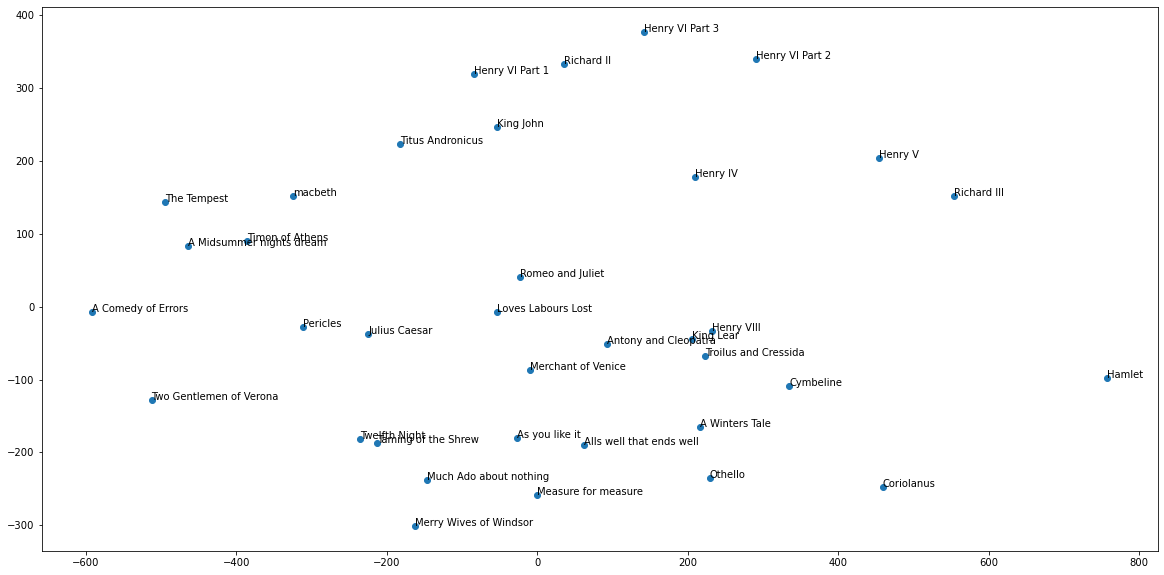

In [12]:
vectorizer = CountVectorizer(vocabulary=vocab)
X = vectorizer.fit_transform(documents)

pca = PCA(n_components=2)
result = pca.fit_transform(X.toarray())
plt.figure(figsize=(20, 10))
plt.scatter(result[:, 0], result[:, 1])
for i, playname in enumerate(playnames):
	plt.annotate(playname, xy=(result[i, 0], result[i, 1]))
plt.show()

# 1.2
The Henry plays are grouped together. The left side of the screen has Two Gentlemen, Comedy of Errors, Midsummer, Tempest, and Pericles all grouped, which are all comedies. Romeo and Juliet, Troilus and Cressida, Antony and Cleopatra all appear in the same general region. In general the groupings are approximately equal to the given genres.

# 1.3

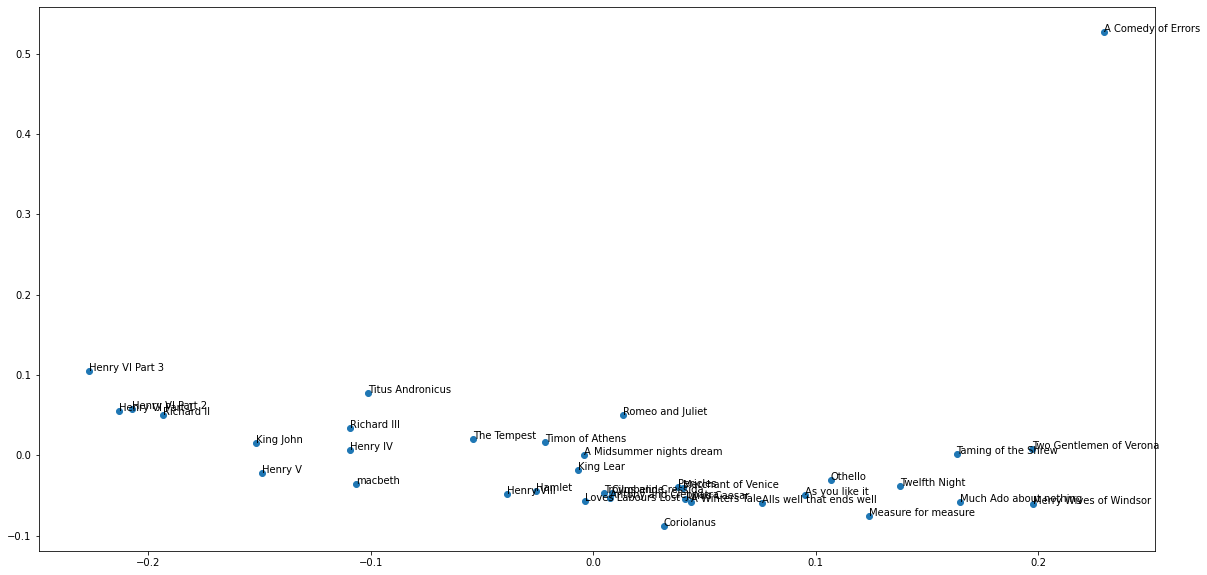

In [13]:
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
#no_comedy_errors = documents.copy()
#no_comedy_errors.pop(playnames.index("A Comedy of Errors"))
tfidf_X = tfidf_vectorizer.fit_transform(documents)

pca = PCA(n_components=2)
tfidf_result = pca.fit_transform(tfidf_X.toarray())
plt.figure(figsize=(20, 10))
plt.scatter(tfidf_result[:, 0], tfidf_result[:, 1])
for i, playname in enumerate(playnames):
	plt.annotate(playname, xy=(tfidf_result[i, 0], tfidf_result[i, 1]))
plt.show()

# 1.4
Apart from the outlier, the overall groupings have not changed very much from the previous section.

# 1.5
Answer is .95, code below

In [14]:
def constructWW(document):
    ww = np.zeros((len(vocab), len(vocab)))
    n = 0
    k = 0
    for sentence in document:
        words = sentence.split(" ")
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                word1 = words[i]
                word2 = words[j]
                try:
                    ww[vocabDic[word1], vocabDic[word2]] += 1
                    ww[vocabDic[word2], vocabDic[word1]] += 1
                    n += 1
                except:
                    k += 1
                    pass
    np.fill_diagonal(ww, 0)
    return ww


In [15]:
ts["5"].astype(str).values

array(['so shaken as we are so wan with care',
       'find we a time for frighted peace to pant',
       'and breathe short winded accents of new broils', ...,
       'each one demand an answer to his part',
       "perform'd in this wide gap of time since first",
       "we were dissever'd hastily lead away"], dtype=object)

In [16]:
vecReps = []
for i in tqdm(range(len(documents))):
    ww = constructWW(documentSents[i])
    vec = 0
    n = 0
    errors = 0
    for word in documents[i].split(" "):
        try:
            vec += ww[vocabDic[word]]
            n += 1
        except:
            pass
    vecReps.append(vec / n)

100%|██████████| 36/36 [00:22<00:00,  1.57it/s]


In [17]:
def self_similarity(vecs):
    avg = 0
    n = 0
    similarities = cosine_similarity(vecs)
    for i in range(similarities.shape[0]):
        for j in range(i + 1, similarities.shape[1]):
            avg += similarities[i, j]
            n += 1
    return avg / n

In [20]:
comedy_vectors = [vecReps[i] for i in COMEDIES]
print(self_similarity(comedy_vectors))

0.9536292460394443


# 1.6

In [21]:
history_vectors = [vecReps[i] for i in HISTORIES]
tragedy_vectors = [vecReps[i] for i in TRAGEDIES]
print(self_similarity(history_vectors))
print(self_similarity(tragedy_vectors))

0.9569009369628788
0.9526832965609966


# 1.7
Similarities given below

In [22]:
print("Comedy-history: ", np.average(cosine_similarity(comedy_vectors, history_vectors)))
print("Comedy-tragedy: ", np.average(cosine_similarity(comedy_vectors, tragedy_vectors)))
print("History-Tragedy: ", np.average(cosine_similarity(history_vectors, tragedy_vectors)))

Comedy-history:  0.9250274395249557
Comedy-tragedy:  0.9464138752065392
History-Tragedy:  0.941995494738899


# 1.8
Answer is .94, given in code below

In [23]:
gensimVecs = []
for i in tqdm(range(len(documentSents))):
    model = Word2Vec(sentences = [x.split(" ") for x in documentSents[i]], vector_size=100, min_count=1)
    vec = 0
    n = 0
    for word in documents[i].split(" "):
        vec += model.wv[word]
        n += 1
    gensimVecs.append(vec / n)
    

100%|██████████| 36/36 [00:08<00:00,  4.48it/s]


In [24]:
comedy_gs_vectors = [gensimVecs[i] for i in COMEDIES]
history_gs_vectors = [gensimVecs[i] for i in HISTORIES]
tragedy_gs_vectors = [gensimVecs[i] for i in TRAGEDIES]

In [25]:
print(self_similarity(comedy_gs_vectors))

0.9457928027425494


# 1.9

In [26]:
print(self_similarity(history_gs_vectors))
print(self_similarity(tragedy_gs_vectors))

0.9406289309263229
0.9473096141309449


# 1.10

In [77]:
print("Comedy-history: ", np.average(cosine_similarity(comedy_gs_vectors, history_gs_vectors)))
print("Comedy-tragedy: ", np.average(cosine_similarity(comedy_gs_vectors, tragedy_gs_vectors)))
print("History-Tragedy: ", np.average(cosine_similarity(history_gs_vectors, tragedy_gs_vectors)))

Comedy-history:  0.94129235
Comedy-tragedy:  0.9450812
History-Tragedy:  0.9408452


# 1.11
Answer is .95, given below

In [27]:
rawDocuments = []
rawDocumentSents = []
rawPlaynames = []
for i in shakespeare.groupby(1):
    playname = i[0]
    rawPlaynames.append(playname)
    play = i[1]
    rawDocuments.append(" ".join(play[5].astype(str).values))
    rawDocumentSents.append(play[5].astype(str).values)

In [17]:
#labseVectors = []
#model = SentenceTransformer('sentence-transformers/LaBSE')
#for i in tqdm(range(len(rawDocumentSents))):
    #embeddings = model.encode(rawDocumentSents[i])
    #labseVectors.append(embeddings)

100%|██████████| 36/36 [31:36<00:00, 52.69s/it]


In [18]:
#with open("labse.txt", "wb") as file:
    #pickle.dump(labseVectors, file)

In [28]:
with open("labse.txt", "rb") as file:
    labseVectors = pickle.load(file)
playnames == rawPlaynames

True

In [29]:
comedy_labse_vectors = [np.average(labseVectors[i], axis = 0) for i in COMEDIES]
history_labse_vectors = [np.average(labseVectors[i], axis = 0) for i in HISTORIES]
tragedy_labse_vectors = [np.average(labseVectors[i], axis = 0) for i in TRAGEDIES]

In [31]:
print(self_similarity(comedy_labse_vectors))

0.9514919905435472


# 1.12

In [32]:
print(self_similarity(history_labse_vectors))
print(self_similarity(tragedy_labse_vectors))

0.9592306133773592
0.9575900020021381


# 1.13

In [33]:
print("Comedy-history: ", np.average(cosine_similarity(comedy_labse_vectors, history_labse_vectors)))
print("Comedy-tragedy: ", np.average(cosine_similarity(comedy_labse_vectors, tragedy_labse_vectors)))
print("History-Tragedy: ", np.average(cosine_similarity(history_labse_vectors, tragedy_labse_vectors)))

Comedy-history:  0.9218119
Comedy-tragedy:  0.94546825
History-Tragedy:  0.9365065


# 1.14
LABSE gives the best measures of similarities, probably because it can embed entire sentences and is therefore able to gain more context for each embedding.

In [31]:
#model = SentenceTransformer('sentence-transformers/LaBSE')
#all_lines_labse = model.encode(shakespeare[5].values)

In [34]:
#with open("all_lines_labse.txt", "wb") as file:
    #pickle.dump(all_lines_labse, file)

# 1.15
For this one I only plotted characters that spoke at least 200 lines, to avoid overcluttering the graph. This still results in 178 characters being plotted.

In [12]:
with open("all_lines_labse.txt", "rb") as file:
    all_lines_labse = np.array(pickle.load(file))

In [15]:
len(shakespeare[4].unique())

934

In [45]:
characters = []
char_vecs = []
for character, df in shakespeare.groupby(4):
    indices = df.index
    if len(indices) >= 200:
        characters.append(character)
        char_vecs.append(np.average(all_lines_labse[indices], axis=0))
char_vecs = np.array(char_vecs)
char_vecs.shape

(178, 768)

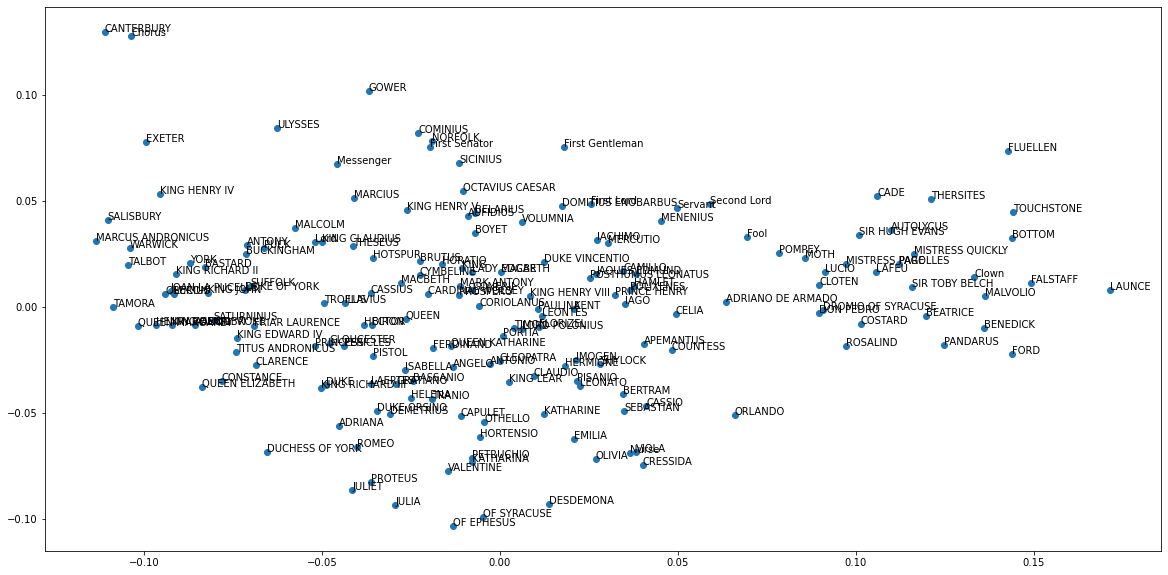

In [46]:
pca = PCA(n_components=2)
result = pca.fit_transform(char_vecs)
plt.figure(figsize=(20, 10))
plt.scatter(result[:, 0], result[:, 1])
for i, character in enumerate(characters):
	plt.annotate(character, xy=(result[i, 0], result[i, 1]))
plt.show()

# 1.15
We get some interesting groupings, such that male Greek and Roman characters like Gower, Ulysses, Cominius, Sicinius, Mascius, Octavius Caesar are grouped together. When characters deviate from the central cluster, they tend to have a similarities. Another interesting group is in the bottom of the chart where a number of female characters have been grouped. Romeo and Juliet appear very close to each other, as we might expect.

# 2.1
Lengths of the three corpuses are given below

In [34]:
with open("arthur_conan_doyle.txt", "r", encoding="utf8") as file1, open("jane_austen.txt", "r", encoding="utf8") as file2:
    arthur = file1.read()
    jane = file2.read()
len(arthur), len(jane)

(8207421, 4353617)

In [52]:
def tokenize_work(x):
    nlp = spacy.load("en_core_web_sm")
    sentences = []
    for i in tqdm(range(0, len(x), 500000)):
        chunk = x[i : min(len(x), i + 500000)]
        for sent in nlp(chunk).sents:
            sentences.append([token.lemma_.lower() for token in sent if not token.is_punct and not token in nlp.Defaults.stop_words])
    return sentences
        

In [36]:
#tokenized_arthur = tokenize_work(arthur)
#with open("tokenized_arthur.txt", "wb") as file:
    #pickle.dump(tokenized_arthur, file)

100%|██████████| 17/17 [07:41<00:00, 27.17s/it]


In [53]:
#tokenized_jane = tokenize_work(jane)
#with open("tokenized_jane.txt", "wb") as file:
    #pickle.dump(tokenized_jane, file)

100%|██████████| 9/9 [03:52<00:00, 25.83s/it]


In [54]:
#tokenized_shakespeare = tokenize_work(" ".join(shakespeare[5].values))
#with open("tokenized_shakespeare_q2.txt", "wb") as file:
    #pickle.dump(tokenized_shakespeare, file)

100%|██████████| 9/9 [03:47<00:00, 25.30s/it]


In [35]:
with open("tokenized_arthur.txt", "rb") as file1, open("tokenized_jane.txt", "rb") as file2, open("tokenized_shakespeare_q2.txt", "rb") as file3:
    tokenized_arthur = pickle.load(file1)
    tokenized_jane = pickle.load(file2)
    tokenized_shakespeare = pickle.load(file3)

In [36]:
words = ["courage", "hope", "love", "woman", "man", "he", "she", "good", "bad","evil","beauty", "fate"] + ["england", "war", "peace"]

In [37]:
arthurWV = Word2Vec(sentences = tokenized_arthur, vector_size=100, min_count=1)
janeWV = Word2Vec(sentences = tokenized_jane, vector_size=100, min_count=1)
shakespeareWV = Word2Vec(sentences = tokenized_shakespeare, vector_size=100, min_count=1)

# Vocabulary sizes

In [38]:
len(arthurWV.wv), len(janeWV.wv), len(shakespeareWV.wv)

(25738, 13758, 19967)

# 2.2/2.3
All answers given here. I added england, war, and peace as additional words.

In [73]:
for word in words:
    print("Word: ", word)
    print("Closest words in Doyle: ", [x[0] for x in arthurWV.wv.most_similar(word, topn=3)])
    print("Closest words in Austen: ", [x[0] for x in janeWV.wv.most_similar(word, topn=3)])
    print("Closest words in Shakespeare: ", [x[0] for x in shakespeareWV.wv.most_similar(word,topn=3)])

Word:  courage
Closest words in Doyle:  ['temper', 'affection', 'pride']
Closest words in Austen:  ['cease', 'voluntarily', 'mislead']
Closest words in Shakespeare:  ['amity', 'guilt', 'society']
Word:  hope
Closest words in Doyle:  ['promise', 'trouble', 'help']
Closest words in Austen:  ['trust', 'wish', 'suppose']
Closest words in Shakespeare:  ['content', 'comfort', 'faith']
Word:  love
Closest words in Doyle:  ['hate', 'hurt', 'marry']
Closest words in Austen:  ['regard', 'acquaint', 'attach']
Closest words in Shakespeare:  ['praise', 'wrong', 'wish']
Word:  woman
Closest words in Doyle:  ['girl', 'lady', 'child']
Closest words in Austen:  ['man', 'person', 'girl']
Closest words in Shakespeare:  ['man', 'maid', 'fool']
Word:  man
Closest words in Doyle:  ['woman', 'person', 'fellow']
Closest words in Austen:  ['woman', 'person', 'people']
Closest words in Shakespeare:  ['thing', 'woman', 'fool']
Word:  he
Closest words in Doyle:  ['himself', 'she', 'i']
Closest words in Austen:  [

# 2.4
The second closest word to woman in Doyle is lady, while for Shakespeare it is maid. This could reflect a significant difference in the descriptions of women from different time periods, since Doyle lived 300 years after Shakespeare. Another difference is that for Doyle and Austen, the closest words to good are happy and kind, while for Shakespeare it is madam. Doyle and Austen use good to describe a state of being, Shakespeare seems to use it as a title.

# 2.5

In [92]:
with open("questions-words.txt", "r") as file:
    analogies = [x.lower().strip() for x in file.readlines()]
len(analogies), analogies[0], analogies[-1]

(19558, ': capital-common-countries', 'write writes work works')

In [111]:
def checkAnalogy(analogy, model):
    try:
        firstWord, secondWord, thirdWord, fourthWord = analogy.split(" ")
    except:
        return "oov"
    
    try:
        leftSide = model.wv[firstWord] - model.wv[secondWord] + model.wv[fourthWord]
        closest = model.wv.most_similar(leftSide, topn=1)[0][0]
        if closest == thirdWord:
            return 1
        else:
            return 0
    except:
        return "oov"

In [112]:
doyleAcc, austenAcc, shakeAcc, doyleN, austenN, shakeN = 0, 0, 0, 0, 0, 0
for analogy in analogies:
    doyleResult = checkAnalogy(analogy, arthurWV)
    if doyleResult != "oov":
        doyleN += 1
        if doyleResult == 1:
            doyleAcc += 1
    austenResult = checkAnalogy(analogy, janeWV)
    if austenResult != "oov":
        austenN += 1
        if austenResult == 1:
            austenAcc += 1
    shakeResult = checkAnalogy(analogy, shakespeareWV)
    if shakeResult != "oov":
        shakeN += 1
        if shakeResult == 1:
            shakeAcc += 1

    

In [113]:
doyleAcc / doyleN, austenAcc / austenN, shakeAcc / shakeN

(0.0012348728081007657, 0.005145797598627788, 0.0032530904359141183)

# 2.6
Austen had the best score for analogies, Shakespeare the second best, and Doyle the worst. Training on the Austen corpus then gives us the best commonsense representation. This is probably a flawed way to measure word representations since a very large number of analogies will be out of vocabulary, and the specific context of the text will affect these analogy representations. For example, a model trained on a WWII corpus will likely have a different interpretation of London and Berlin than a model trained on a corpus of encyclopedias will.